In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


ImportError: cannot import name 'SMOTER' from 'imblearn.over_sampling' (C:\Users\ngjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\over_sampling\__init__.py)

In [8]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [9]:
# Transform data

# Map age group to integer
avg_age_mapping = {
    '0-14': 7,
    '15-24': 20,
    '25-44': 33,
    '45-64': 55,
    '65+': 75
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['average_age'] = df['age'].map(avg_age_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Impute missing values in 'average_age' with the mean
df['average_age'] = df['average_age'].fillna(df['average_age'].mean())

# Impute missing values in 'gender_idx' and 'ethnicity_idx' with the mode
df['gender_idx'] = df['gender_idx'].fillna(df['gender_idx'].mode()[0])
df['ethnicity_idx'] = df['ethnicity_idx'].fillna(df['ethnicity_idx'].mode()[0])

# Convert the specified columns to floats
df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
    'dec_tobacco_supply', 'dec_smoking_uptake']] = df[['tax_increase', 'outlet_reduction', 
    'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake']].apply(pd.to_numeric, errors='coerce').astype('float')

# Display updated DataFrame
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc,average_age,gender_idx,ethnicity_idx
1,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725,7.0,0.0,1.0
2,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675,20.0,0.0,1.0
3,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314,33.0,0.0,1.0
4,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,1.0,0.0,0.0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181,55.0,0.0,1.0
5,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,0.5,0.0,0.0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651,75.0,0.0,1.0


In [12]:
df_corr = df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'gender_idx', 'ethnicity_idx',
                 'qalys_pc', 'hs_costs_pc']]

# Get the pairwise correlation of all columns
correlation_matrix = df_corr.corr()

# Filter pairs with correlation greater than 0.4 or less than -0.4
strong_corr = correlation_matrix[(correlation_matrix > 0.4) | (correlation_matrix < -0.4)]

# Remove self-correlations (diagonal elements of 1)
strong_corr = strong_corr.where(np.triu(np.ones(strong_corr.shape), k=1).astype(bool))

# Display the pairs with strong correlation
strong_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

,dec_tobacco_supply,ethnicity_idx,qalys_pc,hs_costs_pc
0,,,,
tax_increase,-0.492615,NaN,NaN,0.562500
outlet_reduction,-0.496465,NaN,NaN,0.455710
dec_smoking_prevalence,0.475344,-0.540893,0.840047,-0.591510
dec_tobacco_supply,NaN,NaN,NaN,-0.423889
average_age,NaN,NaN,-0.424494,NaN
ethnicity_idx,NaN,NaN,-0.490915,NaN
qalys_pc,NaN,NaN,NaN,-0.468802


In [19]:
# Set random seed for reproducibility
np.random.seed(42)

# Define dependent and independent variables
X = np.array(df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'hs_costs_pc',
                   'gender_idx', 'ethnicity_idx']])

y = np.array(df['qalys_pc'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)

# Define the number of duplicates
n_duplicates = 10

# Duplicate X_train and y_train
X_train_dup = np.concatenate([X_train for _ in range(n_duplicates)], axis=0)
y_train_dup = np.concatenate([y_train for _ in range(n_duplicates)], axis=0)

# Add Gaussian noise to the first 6 columns of X_train_dup
X_train_dup[:, :6] += np.random.normal(0, 0.01, X_train_dup[:, :6].shape)

# Add Gaussian noise to both columns of y_train_dup
y_train_dup += np.random.normal(0, 0.01, y_train_dup.shape)

In [20]:
# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [5, 10, 20],            # Depth of the trees
    'min_child_weight': [1, 5, 10],     # Minimum sum of instance weight (hessian)
    'reg_lambda': [0.01, 0.1, 1, 10],  # L2 regularization term (lambda)
    'reg_alpha': [0.01, 0.1, 1, 10],      # L1 regularization term (alpha)
}

# Define the MAPE scorer (as we are optimizing based on Mean Absolute Percentage Error)
mape_scorer = make_scorer(mape, greater_is_better=False)

# Setup GridSearchCV to perform cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the duplicated training data
grid_search.fit(X_train_dup, y_train_dup)

# Best hyperparameters from grid search
print("Best Parameters:", grid_search.best_params_)

# Best MAPE score from cross-validation
print("Best MAPE:", -grid_search.best_score_)

# Train a final model using the best parameters
best_xgb_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate the test MAPE
test_mape = mape(y_test, y_pred)
print("Test MAPE:", test_mape)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\ngjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.01}
Best MAPE: 0.07048707052859693
Test MAPE: 1.5915390706434227


In [21]:
# Define the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42, bootstrap=True)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [5, 10, 20],            # Maximum depth of the tree
    'min_samples_leaf': [1, 5, 10],      # Minimum number of samples required to be at a leaf node
    'max_samples': [0.5, 0.7, 1.0],     # Maximum number of samples to draw from the data with replacement
}

# Define the MAPE scorer (using Mean Absolute Percentage Error)
mape_scorer = make_scorer(mape, greater_is_better=False)

# Setup GridSearchCV to perform cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                              scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the duplicated training data
grid_search_rf.fit(X_train_dup, y_train_dup)

# Best hyperparameters from grid search
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Best MAPE score from cross-validation
print("Best MAPE for Random Forest:", -grid_search_rf.best_score_)

# Train a final model using the best parameters
best_rf_model = grid_search_rf.best_estimator_

# Evaluate on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate the test MAPE
test_mape_rf = mape(y_test, y_pred_rf)
print("Test MAPE for Random Forest:", test_mape_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_samples': 1.0, 'min_samples_leaf': 1, 'n_estimators': 300}
Best MAPE for Random Forest: 0.06931172191353045
Test MAPE for Random Forest: 1.373434919023165


In [22]:
# Define the RandomForestRegressor model with bootstrap disabled
rf_model_no_bootstrap = RandomForestRegressor(random_state=42, bootstrap=False)

# Define the parameter grid to search over
param_grid_no_bootstrap = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [3, 5, 10],            # Maximum depth of the tree
    'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required to be at a leaf node
}

# Define the MAPE scorer (using Mean Absolute Percentage Error)
mape_scorer = make_scorer(mape, greater_is_better=False)

# Setup GridSearchCV to perform cross-validation
grid_search_rf_no_bootstrap = GridSearchCV(estimator=rf_model_no_bootstrap, param_grid=param_grid_no_bootstrap, 
                                           scoring=mape_scorer, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the duplicated training data
grid_search_rf_no_bootstrap.fit(X_train_dup, y_train_dup)

# Best hyperparameters from grid search
print("Best Parameters for Random Forest (No Bootstrap):", grid_search_rf_no_bootstrap.best_params_)

# Best MAPE score from cross-validation
print("Best MAPE for Random Forest (No Bootstrap):", -grid_search_rf_no_bootstrap.best_score_)

# Train a final model using the best parameters
best_rf_model_no_bootstrap = grid_search_rf_no_bootstrap.best_estimator_

# Evaluate on the test set
y_pred_rf_no_bootstrap = best_rf_model_no_bootstrap.predict(X_test)

# Calculate the test MAPE
test_mape_rf_no_bootstrap = mape(y_test, y_pred_rf_no_bootstrap)
print("Test MAPE for Random Forest (No Bootstrap):", test_mape_rf_no_bootstrap)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest (No Bootstrap): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best MAPE for Random Forest (No Bootstrap): 0.022180710126032795
Test MAPE for Random Forest (No Bootstrap): 1.6118707613692003


Explained variance by component 1: 0.28
Explained variance by component 2: 0.19


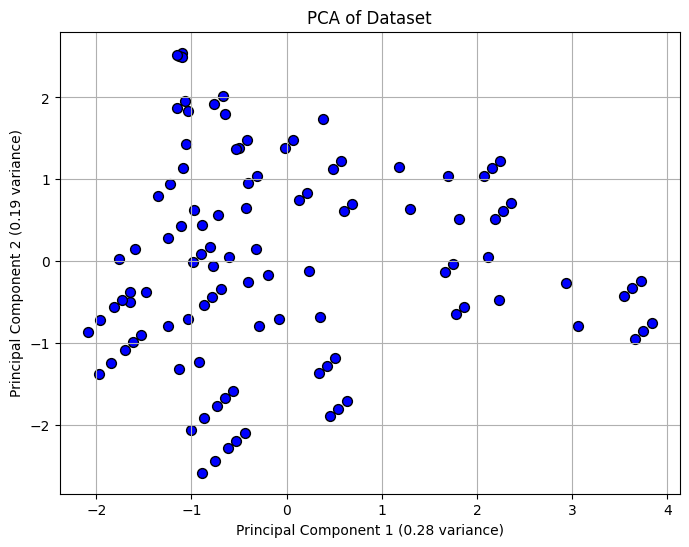

In [23]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio for the first two components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
print(f"Explained variance by component 2: {explained_variance[1]:.2f}")

# Create a scatter plot of the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50)

# Add labels and title
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f} variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f} variance)")
plt.title("PCA of Dataset")
plt.grid(True)

# Show plot
plt.show()